In [95]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import functools

In [180]:
plate_path = "/content/69_JIM_42471.png"

In [181]:
letter_to_class = {"ALEF": 10, "BE": 11, "PE": 12, "TE": 13, "SE": 14, "JIM": 15, "CHE": 16, "HEY": 17, "KHE": 18, "DAL": 19, "ZAL":20, "RE":21, "ZE": 22, "ZHE": 23,
                   "SIN": 24, "SHIN": 25, "SAD": 26, "ZAD": 27, "TA": 28, "ZA": 29, "EIN": 30, "GHEIN": 31, "FE": 32, "GHAF": 33, "KAF": 34, "GAF": 35, "LAM": 36, "MIM": 37, "NON": 38,
                   "VAV": 39, "HE": 40, "YE": 41}

plate = plate_path.split("/")[-1].split(".")[0]

p1, p2, p3 = plate.split("_")
classes = [int(p1[0]), int(p1[1]), letter_to_class[p2], int(p3[0]), int(p3[1]), int(p3[2]), int(p3[3]), int(p3[4])]

classes

[6, 9, 15, 4, 2, 4, 7, 1]

In [182]:
img = cv2.imread(plate_path)

In [6]:
def pltImshow(img):
    b,g,r=cv2.split(img)
    img_matplotlib=cv2.merge([r,g,b])
    plt.imshow(img_matplotlib)

In [184]:
img.shape

(70, 312, 3)

In [185]:
img[:,:30,:] = 255
img[:,235:242,:] = 255

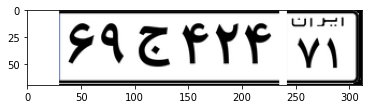

In [186]:
pltImshow(img)

In [187]:
image = cv2.copyMakeBorder(img, 100, 100, 100, 100, cv2.BORDER_CONSTANT)

In [188]:
pad_x = 100
pad_y = 100

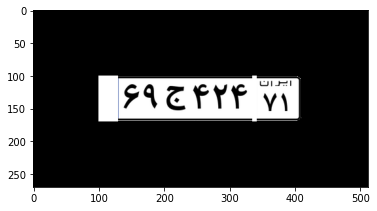

In [189]:
pltImshow(image)

In [190]:
height, width = img.shape[:2]
height, width

(70, 312)

In [191]:
const_h = 15
const_w = 10
inp = np.float32([[pad_x,pad_y],
                  [pad_x + width-1,pad_y],
                  [pad_x + width-1,pad_y + height-1],
                  [pad_x,pad_y + height-1]])

out = np.float32([[pad_x,pad_y+30],
                  [pad_x + width-1 - const_w,pad_y - 30],
                  [pad_x + width-1 - const_w,pad_y + height-1 - 30],
                  [pad_x,pad_y + height-1 + 30]])

In [192]:
matrix = cv2.getPerspectiveTransform(inp,out)

In [193]:
imgOutput = cv2.warpPerspective(image, matrix, (width+2*pad_x,height+2*pad_y), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

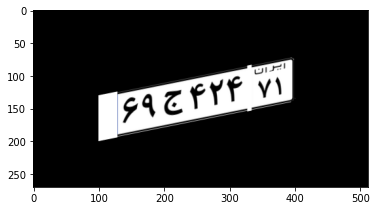

In [194]:
pltImshow(imgOutput)

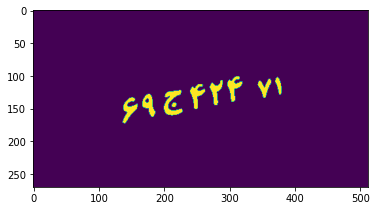

In [195]:
gray=cv2.cvtColor(imgOutput,cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)
plt.imshow(thresh)
_, labels = cv2.connectedComponents(thresh)
mask = np.zeros(thresh.shape, dtype="uint8")
for (i, label) in enumerate(np.unique(labels)):
    # If this is the background label, ignore it
    if label == 0:
        continue
 
    # Otherwise, construct the label mask to display only connected component
    # for the current label
    labelMask = np.zeros(thresh.shape, dtype="uint8")
    labelMask[labels == label] = 255
    numPixels = cv2.countNonZero(labelMask)
 
    # If the number of pixels in the component is between lower bound and upper bound, 
    # add it to our mask
    if numPixels > 40 and numPixels < 800:
        mask = cv2.add(mask, labelMask)
plt.imshow(mask)

In [196]:
cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boundingBoxes = [cv2.boundingRect(c) for c in cnts]

In [197]:
def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]
boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare) )

In [198]:
boundingBoxes[0]

(270, 107, 20, 38)

In [199]:
for box in boundingBoxes:
    x,y,w,h = box
    cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(0,255,0),1)

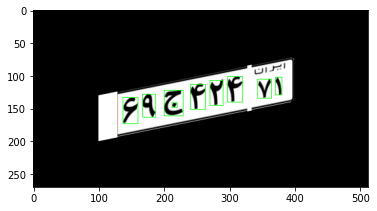

In [200]:
plt.imshow(imgOutput)

In [201]:
merged_boxes = list()
banned = []
for i, box in enumerate(boundingBoxes):
    x,y,w,h = box
    if i not in banned and w > 5 and x > 10:
        for j, box2 in enumerate(boundingBoxes):
            x2,y2,w2,h2 = box2
            if i != j and x2 >= x and x2+w2 <= x+w:
                y = np.min([y,y2])
                h = np.max([y2+h2, y+h]) - y
                banned.append(j)
        merged_boxes.append((x,y,w,h))

In [202]:
imgOutput = cv2.warpPerspective(image, matrix, (width+2*pad_x,height+2*pad_y), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0))

In [203]:
height, width, _ = imgOutput.shape
height, width

(270, 512)

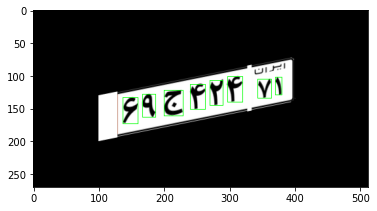

In [210]:
label_file = open("{}.txt".format(plate), 'w')
for i, box in enumerate(sorted(merged_boxes, key=lambda x: x[0])):
    x,y,w,h = box
    
    cv2.rectangle(imgOutput,(x,y),(x+w,y+h),(0,255,0),1)
    x_center = int((x + (0.5) * w)) / width
    y_center = int((y + (0.5) * h)) / height

    label_file.write("{} {} {} {} {}\n".format(classes[i], x_center, y_center, w/width, h/height))

label_file.close()
plt.imshow(imgOutput)

In [40]:
from enum import Enum
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import functools

class Noise(object):
    """
    Each noise should inherite this class and have exact methods of this class
    """
    def __init__(self):
        #init
        pass
        
    def apply(self, img):
        """
        this function gets an image and applies the corresponding noise of class on it
        img: -- cv2 image
        
        return: an image that the noise is applied on
        """
        pass
        # return an image that the noise is applied on
        
class ImageNoise(Noise):
    def __init__(self, pathToImage):
        super()
        self.pathToImage = pathToImage
        
    def apply(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
        im_pil = Image.fromarray(img)
        noise = Image.open(self.pathToImage)
        im_pil.paste(noise, (0,0), mask=noise)
        open_cv_image = np.array(im_pil)[:,:,:-1]
        open_cv_image = open_cv_image[:, :, ::-1].copy()
        return open_cv_image
        
        
def getPrespectiveMatrix(width, height, prespectiveType:int=1,
                         pad:tuple=(100,100,100,100), const_h = 30, const_w = 15):
    """
    get prespective matrix for an image
    """
    p1,p2,p3,p4 = ((pad[2],pad[0]),
                   (pad[2] + width-1,pad[0]),
                   (pad[2] + width-1,pad[0] + height-1),
                   (pad[2],pad[0] + height-1)
                  )
    inp = np.float32([[p1[0],p1[1]],
                    [p2[0],p2[1]],
                    [p3[0],p3[1]],
                    [p4[0],p4[1]]])
    
    if prespectiveType == 1:
        p2 = (p2[0], p2[1] - const_h)
        p3 = (p3[0], p3[1] - const_h)
    elif prespectiveType == 2:
        p2 = (p2[0], p2[1] + const_h)
        p3 = (p3[0], p3[1] + const_h)
    elif prespectiveType == 3:
        p1 = (p1[0], p1[1] - const_h)
        p4 = (p4[0], p4[1] - const_h)
    elif prespectiveType == 4:
        p1 = (p1[0], p1[1] + const_h)
        p4 = (p4[0], p4[1] + const_h)
    elif prespectiveType == 5:
        p2 = (p2[0], p2[1] - const_h)
        p3 = (p3[0], p3[1] - const_h)
        
        p1 = (p1[0], p1[1] + const_h)
        p4 = (p4[0], p4[1] + const_h)
    elif prespectiveType == 6:
        p2 = (p2[0], p2[1] + const_h)
        p3 = (p3[0], p3[1] + const_h)
        
        p1 = (p1[0], p1[1] - const_h)
        p4 = (p4[0], p4[1] - const_h)
    else:
        return None
    
    out = np.float32([[p1[0],p1[1]],
                    [p2[0],p2[1]],
                    [p3[0],p3[1]],
                    [p4[0],p4[1]]])
    
    return cv2.getPerspectiveTransform(inp,out)


def createPrespective(pathToImage:str, noises:list ,pathToNoise:str=None,
                      prespectiveType:int=0, pad:tuple=(100,100,100,100)):
    """
    This function applies prespective to the image with the given path
    
    Keyword arguments:
    pathToImage -- path to the image file in png format (string)
    prespectiveType -- type of prespective (integer between 0 to 6), if 0 acts random o.w a specific prespective
            would be applied
    pad -- padding for the image (top,bottom,left,right)
    
    returns -- a tuple: (altered image with prespective good for bounding box extraction, original image that
                            with paddings and same prespective)
    """
    
    if not pathToImage.endswith('.png'):
        raise Exception('Only png files are supported.')
    if type(prespectiveType) != int or prespectiveType not in range(0,7):
        raise Exception('prespectiveType argument must be and integer between 1 to 6.')
    if type(pad) != tuple or len(pad) != 4:
        raise Exception('pad argument must be a tuple of size 4 with integers inside')
        
    img = cv2.imread(pathToImage)
    before_altering = img.copy()
    
    for noise in noises:
        before_altering = noise.apply(before_altering)
        
    bg = img[10,35,:]
    img[:,:32,:] = bg
    img[:,235:242,:] = bg
    img[:6,:,:] = bg
    img[:,-6:,:] = bg
    img[-5:,:,:] = bg
    img[:20,242:300,:] = bg
    height, width = img.shape[:2]
    img = cv2.copyMakeBorder(img, pad[0], pad[1], pad[2], pad[3], cv2.BORDER_CONSTANT)
    before_altering = cv2.copyMakeBorder(before_altering, pad[0], pad[1], pad[2], pad[3], cv2.BORDER_CONSTANT)
    pType = prespectiveType
    if prespectiveType == 0:
        pType = np.random.randint(1,7)
    matrix = getPrespectiveMatrix(width, height,pType)
    newHeight, newWidth = img.shape[:2]
    imgOutput = cv2.warpPerspective(img, matrix, (newWidth,newHeight),
                                              cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                              borderValue=(0,0,0))
    before_altering = cv2.warpPerspective(before_altering, matrix, (newWidth,newHeight),
                                              cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,
                                              borderValue=(0,0,0))
    return (before_altering, imgOutput)

def compare(rect1, rect2):
    if abs(rect1[1] - rect2[1]) > 10:
        return rect1[1] - rect2[1]
    else:
        return rect1[0] - rect2[0]

def getBoundingBoxes(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blurred, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 45, 15)
    _, labels = cv2.connectedComponents(thresh)
    mask = np.zeros(thresh.shape, dtype="uint8")
    for (i, label) in enumerate(np.unique(labels)):
        # If this is the background label, ignore it
        if label == 0:
            print("daaah!")
            continue

        # Otherwise, construct the label mask to display only connected component
        # for the current label
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv2.countNonZero(labelMask)

        # If the number of pixels in the component is between lower bound and upper bound, 
        # add it to our mask
        if numPixels > 5 and numPixels < 800:
            mask = cv2.add(mask, labelMask)
            
    cnts, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    boundingBoxes = sorted(boundingBoxes, key=functools.cmp_to_key(compare))
    
    merged_boxes = list()
    banned = []
    for i, box in enumerate(boundingBoxes):
        x,y,w,h = box
        if i not in banned:
            for j, box2 in enumerate(boundingBoxes):
                x2,y2,w2,h2 = box2
                if i != j and x2 >= x and x2+w2 <= x+w:
                    y = np.min([y,y2])
                    h = np.max([y2+h2, y+h]) - y
                    banned.append(j)
            merged_boxes.append((x,y,w,h))
    return merged_boxes,boundingBoxes




In [34]:
brightness = 130
contrast = 50
img2 = np.int16(img)
img2 = img2 * (contrast/127+1) - contrast + brightness
img2 = np.clip(img2, 0, 255)
img2 = np.uint8(img2)

In [35]:
img = cv2.imread('./69_JIM_42471.png')

In [36]:
pltImshow(img)

NameError: name 'pltImshow' is not defined

In [37]:
pltImshow(img2)

NameError: name 'pltImshow' is not defined

In [38]:
imageNoise = ImageNoise('./noise/noise1.png')

daaah!


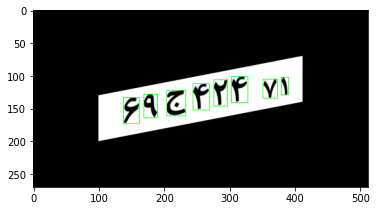

In [43]:
original, prespective_img = createPrespective('./69_JIM_42471.png', noises=[imageNoise])
## get bounding boxes and plot them
mergedBoxes,bb = getBoundingBoxes(prespective_img)
for box in mergedBoxes:
    x,y,w,h = box
    cv2.rectangle(prespective_img,(x,y),(x+w,y+h),(0,255,0),1)
    cv2.rectangle(prespective_img,(x,y),(x+w,y+h),(0,255,0),1)
plt.imshow(prespective_img)


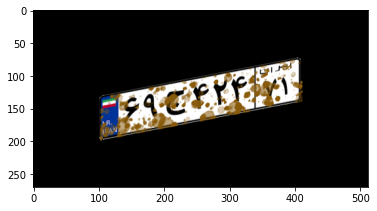

In [44]:
plt.imshow(original[:,:,::-1])